## 1. Sound it out!
<p>Grey and Gray. Colour and Color. Words like these have been the cause of many heated arguments between Brits and Americans. Accents (and jokes) aside, there are many words that are pronounced the same way but have different spellings. While it is easy for us to realize their equivalence, basic programming commands will fail to equate such two strings. </p>
<p>More extreme than word spellings are names because people have more flexibility in choosing to spell a name in a certain way. To some extent, tradition sometimes governs the way a name is spelled, which limits the number of variations of any given English name. But if we consider global names and their associated English spellings, you can only imagine how many ways they can be spelled out. </p>
<p>One way to tackle this challenge is to write a program that checks if two strings sound the same, instead of checking for equivalence in spellings. We'll do that here using fuzzy name matching.</p>

In [2]:
# Importing the fuzzy package
import fuzzy

# Exploring the output of fuzzy.nysiis
print(fuzzy.nysiis('Colour'))

# Testing equivalence of similar sounding words
fuzzy.nysiis('Colour') == fuzzy.nysiis('Color')

CALAR


True

## 2. Authoring the authors
<p>The New York Times puts out a weekly list of best-selling books from different genres, and which has been published since the 1930’s.  We’ll focus on Children’s Picture Books, and analyze the gender distribution of authors to see if there have been changes over time. We'll begin by reading in the data on the best selling authors from 2008 to 2017.</p>

In [4]:
# Importing the pandas module
import pandas as pd

# Reading in datasets/nytkids_yearly.csv, which is semicolon delimited.
author_df = pd.read_csv('datasets/nytkids_yearly.csv',sep=';')

# Looping through author_df['Author'] to extract the authors first names
first_name = []
for name in author_df.Author:
    first_name.append(name.split(' ')[0])

# Adding first_name as a column to author_df
author_df['first_name'] = pd.Series(first_name)

# Checking out the first few rows of author_df
author_df.head()

,Year,Book Title,Author,Besteller this year,first_name
0,2017,DRAGONS LOVE TACOS,Adam Rubin,49,Adam
1,2017,THE WONDERFUL THINGS YOU WILL BE,Emily Winfield Martin,48,Emily
2,2017,THE DAY THE CRAYONS QUIT,Drew Daywalt,44,Drew
3,2017,"ROSIE REVERE, ENGINEER",Andrea Beaty,38,Andrea
4,2017,"ADA TWIST, SCIENTIST",Andrea Beaty,28,Andrea


## 3. It's time to bring on the phonics... _again_!
<p>When we were young children, we were taught to read using phonics; sounding out the letters that compose words. So let's relive history and do that again, but using python this time. We will now create a new column or list that contains the phonetic equivalent of every first name that we just extracted. </p>
<p>To make sure we're on the right track, let's compare the number of unique values in the <code>first_name</code> column and the number of unique values in the nysiis coded column. As a rule of thumb, the number of unique nysiis first names should be less than or equal to the number of actual first names.</p>

In [6]:
# Importing numpy
import numpy as np

# Looping through author's first names to create the nysiis (fuzzy) equivalent
nysiis_name = []
for name in first_name:
    nysiis_name.append(fuzzy.nysiis(name))

# Adding nysiis_name as a column to author_df
author_df['nysiis_name'] = pd.Series(nysiis_name)

# Printing out the difference between unique firstnames and unique nysiis_names:
len(np.unique(first_name)) - len(np.unique(nysiis_name))

25

## 4. The inbetweeners
<p>We'll use <code>babynames_nysiis.csv</code>, a dataset that is derived from <a href="https://www.ssa.gov/oact/babynames/limits.html">the Social Security Administration’s baby name data</a>, to identify author genders. The dataset contains unique NYSIIS versions of baby names, and also includes the percentage of times the name appeared as a female name (<code>perc_female</code>) and the percentage of times it appeared as a male name (<code>perc_male</code>). </p>
<p>We'll use this data to create a list of <code>gender</code>. Let's make the following simplifying assumption: For each name, if <code>perc_female</code> is greater than <code>perc_male</code> then assume the name is female, if <code>perc_female</code> is less than <code>perc_male</code> then assume it is a male name, and if the percentages are equal then it's a "neutral" name.</p>

In [8]:
# Reading in datasets/babynames_nysiis.csv, which is semicolon delimited.
babies_df = pd.read_csv('datasets/babynames_nysiis.csv', sep=';')

# Define gender based on gender percentage
def gender(row):
    if(row.perc_female > row.perc_male):
        return 'F'
    elif(row.perc_female<row.perc_male):
        return 'M'
    else:
        return 'N'

# Apply function and assign to a gender column 
babies_df['gender'] = babies_df.apply(lambda row: gender(row), axis=1)

# Printing out the first few rows of babies_df
babies_df.head()

,babynysiis,perc_female,perc_male,gender
0,NaN,62.50,37.50,F
1,RAX,63.64,36.36,F
2,ESAR,44.44,55.56,M
3,DJANG,0.00,100.00,M
4,PARCAL,25.00,75.00,M


## 5. Playing matchmaker
<p>Now that we have identified the likely genders of different names, let's find author genders by searching for each author's name in the <code>babies_df</code> DataFrame, and extracting the associated gender. </p>

In [10]:
# For a given name (in uppercase) get the gender from the babies_df dataset
def get_gender(name):
    gender_series = babies_df[babies_df['babynysiis']==name].gender
    if gender_series.empty:
        return 'Unknown'
    else:
        return gender_series.iloc[0]
# Apply get_gender to the author_df dataframe
author_df['author_gender'] = author_df.apply(lambda x: get_gender(x.nysiis_name.upper()), axis=1)
# Counts for each gender
author_df.author_gender.value_counts()

F          395
M          191
Unknown      9
N            8
Name: author_gender, dtype: int64

## 6. Tally up
<p>From the results above see that there are more female authors on the New York Times best seller's list than male authors. Our dataset spans 2008 to 2017. Let's find out if there have been changes over time.</p>

In [12]:
# Creating a list of unique years, sorted in ascending order.
years = sorted(author_df.Year.unique())

# Initializing lists
males_by_yr = []
females_by_yr = []
unknown_by_yr = []

# Looping through years to find the number of male, female and unknown authors per year
for year in years:
    counts = author_df[author_df.Year == year].author_gender.value_counts()
    males_by_yr.append(counts['M'])
    females_by_yr.append(counts['F'])
    try:
        unknown_by_yr.append(counts['Unknown'])
    except:
         unknown_by_yr.append(0)

# Printing out yearly values to examine changes over time
print(years)
print(males_by_yr)
print(females_by_yr)
print(unknown_by_yr)
pd.DataFrame(columns = years, index = ['Males','Females','Unknown'], 
             data=[males_by_yr,females_by_yr,unknown_by_yr])

[2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
[8, 19, 27, 21, 21, 11, 21, 18, 25, 20]
[15, 45, 48, 51, 46, 51, 34, 30, 32, 43]
[1, 3, 0, 1, 0, 2, 1, 0, 0, 1]


,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Males,8,19,27,21,21,11,21,18,25,20
Females,15,45,48,51,46,51,34,30,32,43
Unknown,1,3,0,1,0,2,1,0,0,1


## 7. Foreign-born authors?
<p>Our gender data comes from social security applications of individuals born in the US. Hence, one possible explanation for why there are "unknown" genders associated with some author names is because these authors were foreign-born. While making this assumption, we should note that these are only a subset of foreign-born authors as others will have names that have a match in <code>baby_df</code> (and in the social security dataset). </p>
<p>Using a bar chart, let's explore the trend of foreign-born authors with no name matches in the social security dataset.</p>

Text(0.5,1,'')

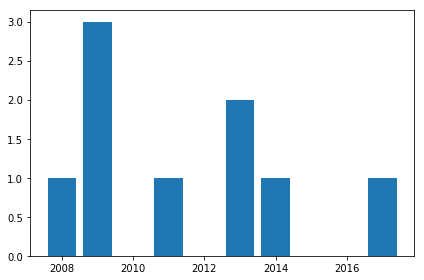

In [14]:
# Importing matplotlib
import matplotlib.pyplot as plt

# This makes plots appear in the notebook
%matplotlib inline

# Plotting the bar chart
ax = plt.bar(years, unknown_by_yr)
plt.title("")

## 8. Raising the bar
<p>What’s more exciting than a bar chart is a grouped bar chart. This type of chart is good for displaying <em>changes</em> over time while also <em>comparing</em> two or more groups. Let’s use a grouped bar chart to look at the distribution of male and female authors over time.</p>

<Container object of 10 artists>

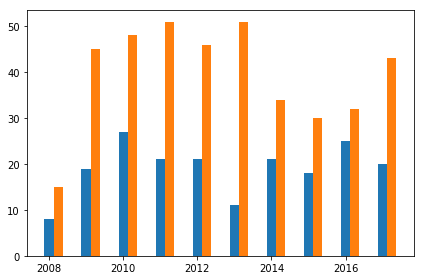

In [23]:
# Creating a new list, where 0.25 is added to each year
years_shifted = np.add(years, 0.25)

# Plotting males_by_yr by year
plt.bar(years, males_by_yr, width=0.25, color='lightblue', label="Male")
# Plotting females_by_yr by years_shifted
plt.bar(years_shifted, females_by_yr, width=0.25, color='pink', label="Female")

# [OPTIONAL] - Adding relevant Axes labels and Chart Title
plt.title("Gender by year")
plt.xlabel()